In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        CoExpression           PCC           PPI  Root10DaysSeedling  \
count  41110.000000  41110.000000  41110.000000        41110.000000   
mean       0.991997     -0.361737      0.914668           -0.522040   
std        0.089101      0.463979      0.279379            0.498568   
min        0.000000     -1.000000      0.000000           -1.000000   
25%        1.000000     -0.747963      1.000000           -0.901371   
50%        1.000000     -0.449089      1.000000           -0.663664   
75%        1.000000     -0.051646      1.000000           -0.378497   
max        1.000000      1.000000      1.000000            1.000000   

       Leaf21DaysSeedling  Leaf45DaysOldPlant  log_2FoldChange            ET  \
count        41110.000000        41110.000000     41110.000000  41110.000000   
mean            -0.828778           -0.585144        -0.037332      1.407395   
std              0.327542            0.399046         0.39

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

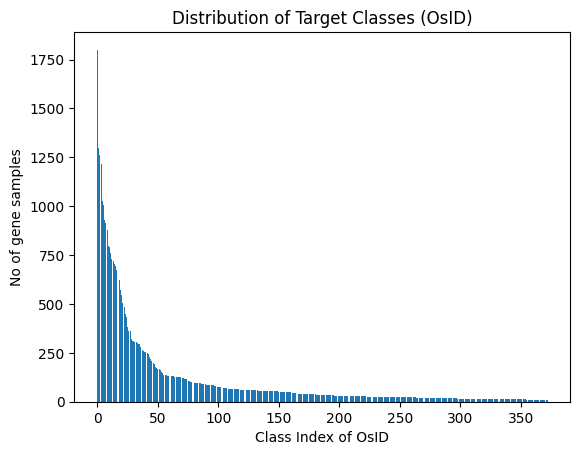

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=20, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/20
1846/1846 [==============================] - 7s 3ms/step - loss: 5.0716 - accuracy: 0.0438 - val_loss: 5.0219 - val_accuracy: 0.0436
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9500 - accuracy: 0.0444 - val_loss: 4.9978 - val_accuracy: 0.0444
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9334 - accuracy: 0.0452 - val_loss: 4.9944 - val_accuracy: 0.0451
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9295 - accuracy: 0.0453 - val_loss: 4.9979 - val_accuracy: 0.0451
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9279 - accuracy: 0.0452 - val_loss: 5.0048 - val_accuracy: 0.0451
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9249 - accuracy: 0.0453 - val_loss: 5.0193 - val_accuracy: 0.0451
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9253 - accuracy: 0.045

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 7s 3ms/step - loss: 5.0805 - accuracy: 0.0450 - val_loss: 4.9943 - val_accuracy: 0.0517
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.8937 - accuracy: 0.0534 - val_loss: 4.9187 - val_accuracy: 0.0528
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.8286 - accuracy: 0.0561 - val_loss: 4.8999 - val_accuracy: 0.0590
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.7994 - accuracy: 0.0568 - val_loss: 4.9058 - val_accuracy: 0.0532
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.7797 - accuracy: 0.0589 - val_loss: 4.8906 - val_accuracy: 0.0460
Epoch 6/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.7655 - accuracy: 0.0560 - val_loss: 4.8885 - val_accuracy: 0.0576
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.7548 - accuracy: 0.0607 - val_loss: 4.9005 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.9321 - accuracy: 0.0698 - val_loss: 4.7730 - val_accuracy: 0.0759
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.6373 - accuracy: 0.0845 - val_loss: 4.7012 - val_accuracy: 0.0785
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 4.5804 - accuracy: 0.0856 - val_loss: 4.6989 - val_accuracy: 0.0770
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.5431 - accuracy: 0.0848 - val_loss: 4.6598 - val_accuracy: 0.0750
Epoch 5/20
1846/1846 [==============================] - 8s 5ms/step - loss: 4.5135 - accuracy: 0.0843 - val_loss: 4.6437 - val_accuracy: 0.0726
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.4890 - accuracy: 0.0863 - val_loss: 4.6389 - val_accuracy: 0.0757
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.4705 - accuracy: 0.0881 - val_loss: 4.6326 - val_accuracy: 0.0849
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 4.4656 - accuracy: 0.1161 - val_loss: 4.0140 - val_accuracy: 0.1602
Epoch 2/20
1846/1846 [==============================] - 6s 4ms/step - loss: 3.6142 - accuracy: 0.2119 - val_loss: 3.5459 - val_accuracy: 0.2440
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1945 - accuracy: 0.2637 - val_loss: 3.2340 - val_accuracy: 0.2946
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9094 - accuracy: 0.3042 - val_loss: 3.0406 - val_accuracy: 0.3058
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7075 - accuracy: 0.3272 - val_loss: 2.8869 - val_accuracy: 0.3351
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5469 - accuracy: 0.3500 - val_loss: 2.7701 - val_accuracy: 0.3382
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4286 - accuracy: 0.3653 - val_loss: 2.6815 - val_accuracy: 0.3615
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.3775 - accuracy: 0.1435 - val_loss: 3.8478 - val_accuracy: 0.1890
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4200 - accuracy: 0.2553 - val_loss: 3.2893 - val_accuracy: 0.2860
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8818 - accuracy: 0.3311 - val_loss: 2.8283 - val_accuracy: 0.3498
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4479 - accuracy: 0.4010 - val_loss: 2.5215 - val_accuracy: 0.3707
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1576 - accuracy: 0.4455 - val_loss: 2.2766 - val_accuracy: 0.4770
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9446 - accuracy: 0.4764 - val_loss: 2.1822 - val_accuracy: 0.4499
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7998 - accuracy: 0.5083 - val_loss: 2.0367 - val_accuracy: 0.5373
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.1943 - accuracy: 0.1852 - val_loss: 3.3664 - val_accuracy: 0.3076
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7234 - accuracy: 0.4162 - val_loss: 2.5603 - val_accuracy: 0.4975
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0696 - accuracy: 0.5337 - val_loss: 2.1129 - val_accuracy: 0.5646
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6593 - accuracy: 0.6179 - val_loss: 1.8310 - val_accuracy: 0.6222
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3783 - accuracy: 0.6705 - val_loss: 1.6281 - val_accuracy: 0.6719
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1882 - accuracy: 0.7063 - val_loss: 1.4566 - val_accuracy: 0.7230
Epoch 7/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0528 - accuracy: 0.7338 - val_loss: 1.3366 - val_accuracy: 0.7153
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.0935 - accuracy: 0.2065 - val_loss: 3.2397 - val_accuracy: 0.3677
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5178 - accuracy: 0.4769 - val_loss: 2.2595 - val_accuracy: 0.5529
Epoch 3/20
1846/1846 [==============================] - 16s 9ms/step - loss: 1.7553 - accuracy: 0.6046 - val_loss: 1.7750 - val_accuracy: 0.6293
Epoch 4/20
1846/1846 [==============================] - 15s 8ms/step - loss: 1.3341 - accuracy: 0.6761 - val_loss: 1.4779 - val_accuracy: 0.6900
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.0813 - accuracy: 0.7246 - val_loss: 1.2532 - val_accuracy: 0.7580
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.9200 - accuracy: 0.7527 - val_loss: 1.1580 - val_accuracy: 0.7591
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.8063 - accuracy: 0.7781 - val_loss: 1.0564 - val_accuracy: 0.7864
E

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 5ms/step - loss: 3.9636 - accuracy: 0.2104 - val_loss: 3.0281 - val_accuracy: 0.3945
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2995 - accuracy: 0.4988 - val_loss: 2.0843 - val_accuracy: 0.5309
Epoch 3/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5974 - accuracy: 0.6197 - val_loss: 1.5935 - val_accuracy: 0.6451
Epoch 4/20
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2143 - accuracy: 0.6905 - val_loss: 1.3341 - val_accuracy: 0.7065
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.9831 - accuracy: 0.7308 - val_loss: 1.1470 - val_accuracy: 0.7461
Epoch 6/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.8367 - accuracy: 0.7666 - val_loss: 0.9897 - val_accuracy: 0.7789
Epoch 7/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.7473 - accuracy: 0.7842 - val_loss: 0.9487 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.8908 - accuracy: 0.2353 - val_loss: 2.8544 - val_accuracy: 0.4400
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0497 - accuracy: 0.5605 - val_loss: 1.7940 - val_accuracy: 0.6442
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2930 - accuracy: 0.7066 - val_loss: 1.3146 - val_accuracy: 0.7342
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.9332 - accuracy: 0.7713 - val_loss: 1.1167 - val_accuracy: 0.7813
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7460 - accuracy: 0.8047 - val_loss: 0.9514 - val_accuracy: 0.8002
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6311 - accuracy: 0.8290 - val_loss: 0.8301 - val_accuracy: 0.8191
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5607 - accuracy: 0.8434 - val_loss: 0.7769 - val_accuracy: 0.8295
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 3.7894 - accuracy: 0.2680 - val_loss: 2.6982 - val_accuracy: 0.5054
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9026 - accuracy: 0.6212 - val_loss: 1.6341 - val_accuracy: 0.7039
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0993 - accuracy: 0.7744 - val_loss: 1.1167 - val_accuracy: 0.8154
Epoch 4/20
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7288 - accuracy: 0.8387 - val_loss: 0.8449 - val_accuracy: 0.8526
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.5439 - accuracy: 0.8703 - val_loss: 0.7104 - val_accuracy: 0.8737
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4453 - accuracy: 0.8885 - val_loss: 0.6317 - val_accuracy: 0.8766
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3857 - accuracy: 0.8991 - val_loss: 0.5839 - val_accuracy: 0.8933
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5721 - accuracy: 0.3086 - val_loss: 2.3528 - val_accuracy: 0.5364
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5383 - accuracy: 0.6973 - val_loss: 1.3586 - val_accuracy: 0.7668
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8947 - accuracy: 0.8054 - val_loss: 0.9558 - val_accuracy: 0.8156
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6273 - accuracy: 0.8544 - val_loss: 0.7535 - val_accuracy: 0.8548
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4829 - accuracy: 0.8810 - val_loss: 0.7530 - val_accuracy: 0.8488
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3969 - accuracy: 0.8992 - val_loss: 0.6024 - val_accuracy: 0.8869
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3413 - accuracy: 0.9107 - val_loss: 0.5594 - val_accuracy: 0.8944
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 3.7413 - accuracy: 0.2917 - val_loss: 2.4122 - val_accuracy: 0.5758
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6221 - accuracy: 0.6902 - val_loss: 1.3767 - val_accuracy: 0.7518
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.9497 - accuracy: 0.8026 - val_loss: 0.9852 - val_accuracy: 0.8125
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6373 - accuracy: 0.8566 - val_loss: 0.7673 - val_accuracy: 0.8561
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4736 - accuracy: 0.8832 - val_loss: 0.6485 - val_accuracy: 0.8746
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3860 - accuracy: 0.8988 - val_loss: 0.5631 - val_accuracy: 0.9032
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3206 - accuracy: 0.9143 - val_loss: 0.5380 - val_accuracy: 0.9017
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 3.3971 - accuracy: 0.3622 - val_loss: 2.1803 - val_accuracy: 0.6491
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4314 - accuracy: 0.7365 - val_loss: 1.2387 - val_accuracy: 0.7872
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8051 - accuracy: 0.8351 - val_loss: 0.8750 - val_accuracy: 0.8612
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5291 - accuracy: 0.8830 - val_loss: 0.7026 - val_accuracy: 0.8739
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3918 - accuracy: 0.9059 - val_loss: 0.5792 - val_accuracy: 0.9023
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3134 - accuracy: 0.9226 - val_loss: 0.5864 - val_accuracy: 0.8790
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2673 - accuracy: 0.9304 - val_loss: 0.4767 - val_accuracy: 0.9111
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5515 - accuracy: 0.3216 - val_loss: 2.3424 - val_accuracy: 0.5448
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5432 - accuracy: 0.7092 - val_loss: 1.3201 - val_accuracy: 0.7626
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8694 - accuracy: 0.8279 - val_loss: 0.8420 - val_accuracy: 0.8572
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5491 - accuracy: 0.8780 - val_loss: 0.6348 - val_accuracy: 0.8884
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3827 - accuracy: 0.9094 - val_loss: 0.5416 - val_accuracy: 0.9107
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3003 - accuracy: 0.9266 - val_loss: 0.4491 - val_accuracy: 0.9217
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2489 - accuracy: 0.9367 - val_loss: 0.4069 - val_accuracy: 0.9355
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5850 - accuracy: 0.3257 - val_loss: 2.4589 - val_accuracy: 0.5608
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6688 - accuracy: 0.6977 - val_loss: 1.4512 - val_accuracy: 0.7476
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.9592 - accuracy: 0.8180 - val_loss: 0.9963 - val_accuracy: 0.8405
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6402 - accuracy: 0.8720 - val_loss: 0.7861 - val_accuracy: 0.8829
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4670 - accuracy: 0.9008 - val_loss: 0.6867 - val_accuracy: 0.8953
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3630 - accuracy: 0.9220 - val_loss: 0.5596 - val_accuracy: 0.9298
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2876 - accuracy: 0.9372 - val_loss: 0.4853 - val_accuracy: 0.9342
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.2629 - accuracy: 0.3758 - val_loss: 1.9366 - val_accuracy: 0.6733
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2719 - accuracy: 0.7607 - val_loss: 1.0980 - val_accuracy: 0.8136
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7322 - accuracy: 0.8525 - val_loss: 0.7762 - val_accuracy: 0.8559
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4928 - accuracy: 0.8893 - val_loss: 0.6148 - val_accuracy: 0.8790
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3697 - accuracy: 0.9082 - val_loss: 0.5535 - val_accuracy: 0.8741
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2996 - accuracy: 0.9228 - val_loss: 0.5077 - val_accuracy: 0.8939
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2586 - accuracy: 0.9321 - val_loss: 0.3928 - val_accuracy: 0.9320
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 3.4158 - accuracy: 0.3502 - val_loss: 2.0248 - val_accuracy: 0.6601
Epoch 2/20
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2628 - accuracy: 0.7639 - val_loss: 1.0359 - val_accuracy: 0.8205
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6601 - accuracy: 0.8620 - val_loss: 0.7264 - val_accuracy: 0.8704
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4370 - accuracy: 0.8992 - val_loss: 0.5418 - val_accuracy: 0.9041
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3293 - accuracy: 0.9200 - val_loss: 0.4768 - val_accuracy: 0.9122
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2727 - accuracy: 0.9285 - val_loss: 0.4388 - val_accuracy: 0.9212
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2341 - accuracy: 0.9398 - val_loss: 0.4002 - val_accuracy: 0.9234
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 3.3482 - accuracy: 0.3861 - val_loss: 2.0832 - val_accuracy: 0.6189
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3748 - accuracy: 0.7470 - val_loss: 1.1701 - val_accuracy: 0.8097
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.7664 - accuracy: 0.8500 - val_loss: 0.8185 - val_accuracy: 0.8543
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.4930 - accuracy: 0.8903 - val_loss: 0.6017 - val_accuracy: 0.9008
Epoch 5/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3661 - accuracy: 0.9134 - val_loss: 0.5635 - val_accuracy: 0.8911
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.2936 - accuracy: 0.9286 - val_loss: 0.4497 - val_accuracy: 0.9063
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2449 - accuracy: 0.9389 - val_loss: 0.4619 - val_accuracy: 0.9162
E

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3713 - accuracy: 0.3656 - val_loss: 2.1615 - val_accuracy: 0.6026
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4091 - accuracy: 0.7356 - val_loss: 1.1659 - val_accuracy: 0.8081
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7600 - accuracy: 0.8477 - val_loss: 0.7832 - val_accuracy: 0.8528
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4776 - accuracy: 0.8901 - val_loss: 0.6299 - val_accuracy: 0.8909
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3408 - accuracy: 0.9202 - val_loss: 0.4882 - val_accuracy: 0.9129
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2680 - accuracy: 0.9357 - val_loss: 0.4662 - val_accuracy: 0.9173
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2354 - accuracy: 0.9424 - val_loss: 0.4077 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 3.2045 - accuracy: 0.3993 - val_loss: 1.8952 - val_accuracy: 0.6530
Epoch 2/20
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1824 - accuracy: 0.7790 - val_loss: 1.0888 - val_accuracy: 0.8246
Epoch 3/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6260 - accuracy: 0.8698 - val_loss: 0.7385 - val_accuracy: 0.8748
Epoch 4/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4182 - accuracy: 0.9024 - val_loss: 0.5495 - val_accuracy: 0.9017
Epoch 5/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3249 - accuracy: 0.9210 - val_loss: 0.5100 - val_accuracy: 0.9127
Epoch 6/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2662 - accuracy: 0.9330 - val_loss: 0.4158 - val_accuracy: 0.9296
Epoch 7/20
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2441 - accuracy: 0.9362 - val_loss: 0.4025 - val_accuracy: 0.9300
Epo

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

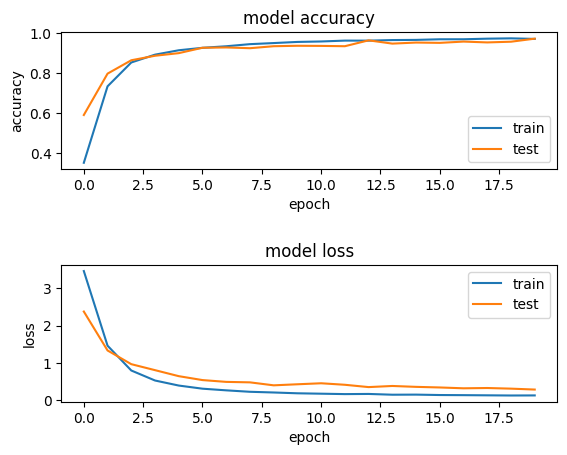

Final Test Accuracy: 0.9795091152191162


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.97      1.00      0.98       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
